In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# VGG 16 모델 적용

- 이미지 데이터 전처리: ImageDataGenerator를 사용하여 이미지 데이터를 로드하고 전처리합니다. VGG16에 적합한 전처리 함수를 사용해야 합니다.

- VGG16 모델 로드: VGG16을 불러오고, 이를 기반으로 새로운 모델을 구성합니다.

- 새로운 톱 레이어 추가: 분류를 위한 새로운 레이어들을 추가합니다.

- 모델 컴파일: 모델을 컴파일합니다. 손실 함수와 옵티마이저를 선택합니다.

- 모델 훈련: 모델을 훈련 데이터로 훈련시키고, 검증 데이터로 검증합니다.

- 평가: 테스트 데이터를 사용하여 모델을 평가합니다.

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model

In [3]:
TRAIN_DATA_DIR = '/content/drive/MyDrive/GDSC/data/train'
VALIDATION_DATA_DIR = '/content/drive/MyDrive/GDSC/data/val'
TEST_DATA_DIR = '/content/drive/MyDrive/GDSC/data/test'

NUM_CLASSES = 7
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 64

In [4]:
# ImageDataGenerator 정의
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [5]:
# 훈련 및 검증 데이터 로더 설정
train_generator = train_datagen.flow_from_directory(
    TRAIN_DATA_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    VALIDATION_DATA_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 1392 images belonging to 7 classes.
Found 157 images belonging to 7 classes.


In [6]:
# VGG16 모델 로드 (톱 레이어 제외)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58889256/58889256 [==============================] - 0s 0us/step


- 추가 부분

전이학습으로 기본 모델인 VGG16 모델의 기본 레이어들이 사전에 학습된 가중치를 유지하고, 추가된 커스텀 레이어만 학습되도록 설정한다.

In [7]:
# 기본 모델의 레이어 학습을 진행하지 않도록 설정
for layer in base_model.layers:
    layer.trainable = False

In [13]:
# # 새로운 톱 레이어 정의
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(1024, activation='relu')(x)
# predictions = Dense(train_generator.num_classes, activation='softmax')(x)


# 커스텀 레이어 추가
x = base_model.output
x = Flatten()(x)  # 기본 모델의 출력을 평탄화
x = Dense(1024, activation='relu')(x)  # 새로운 밀집(Dense) 레이어
x = Dropout(0.5)(x)  # 드롭아웃 추가
predictions = Dense(7, activation='softmax')(x)  # 최종 출력 레이어 (클래스 수에 맞게 조정)


In [14]:
# 전체 모델 구성
model = Model(inputs=base_model.input, outputs=predictions)

- 추가 부분

모델 요약을 확인해서 시각적으로 본다.

In [15]:
# 모델 요약
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   


전이 학습을 사용하면 사전에 학습된 네트워크의 강력한 특징 추출 능력을 활용할 수 있으며, 새로운 작업에 대해 비교적 적은 데이터로도 효과적인 학습이 가능하다.

Non-trainable params가 많다는 것은 사전 훈련된 모델의 대부분의 가중치를 그대로 사용하고 있다는 것을 의미함.

- 왼쪽 모델이 VGG 16 모델 기본 사용
- 오른쪽 모델이 VGG 16 모델에 커스텀해서 변경한 모델 사용
- Flatten과 추가적인 Dense, Dropout 레이어로 파라미터 늘림
- 전이학습으로 사전 가중치 유지하고 추가된 커스텀 레이버만 학습되도록 정

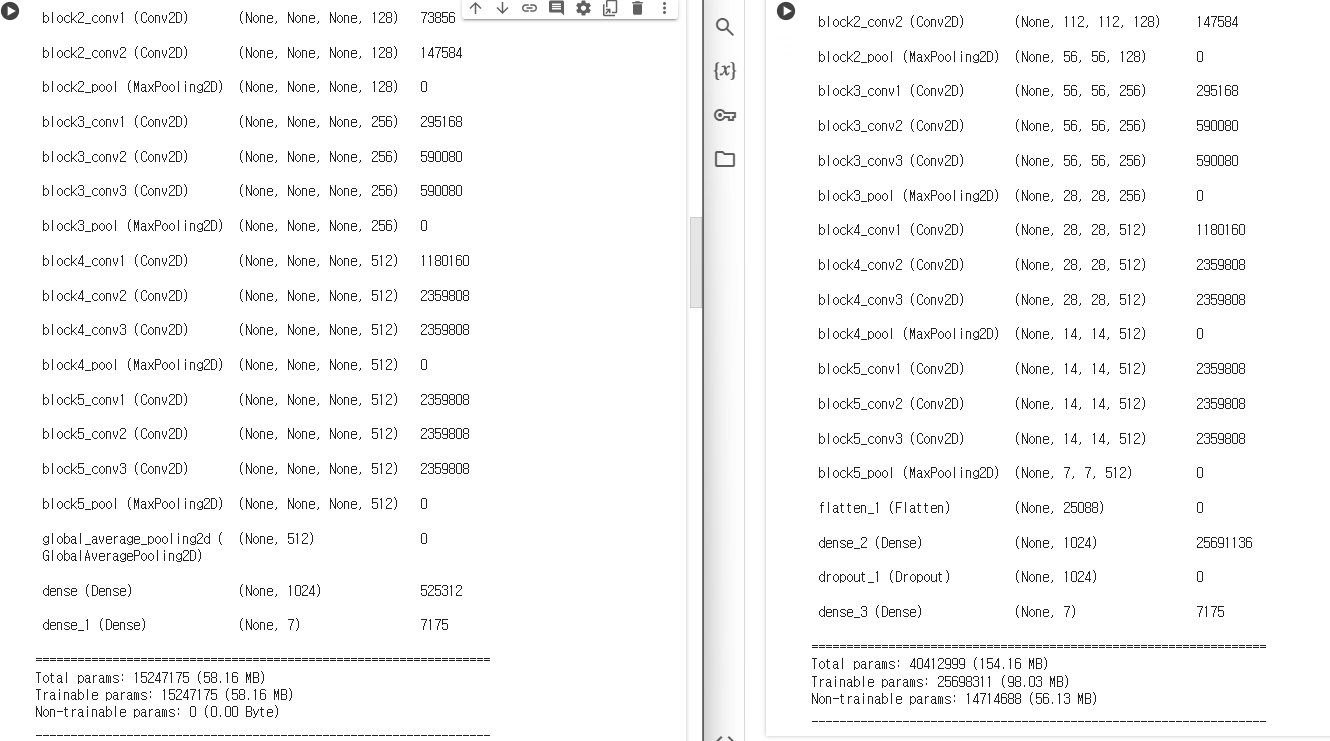

In [16]:
# 모델 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


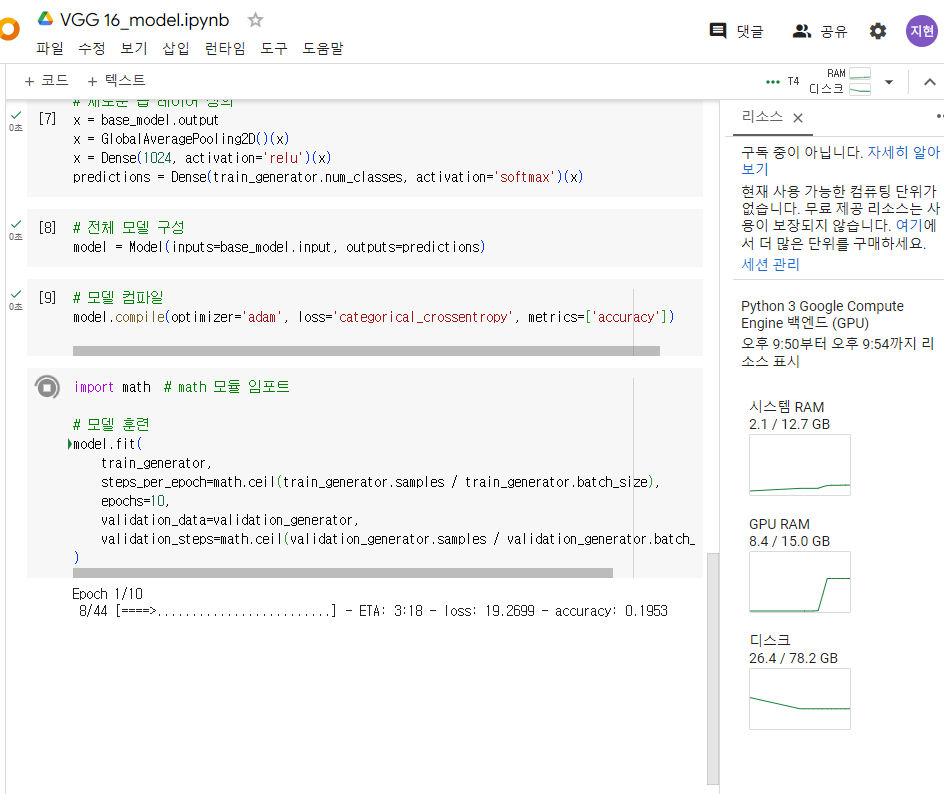

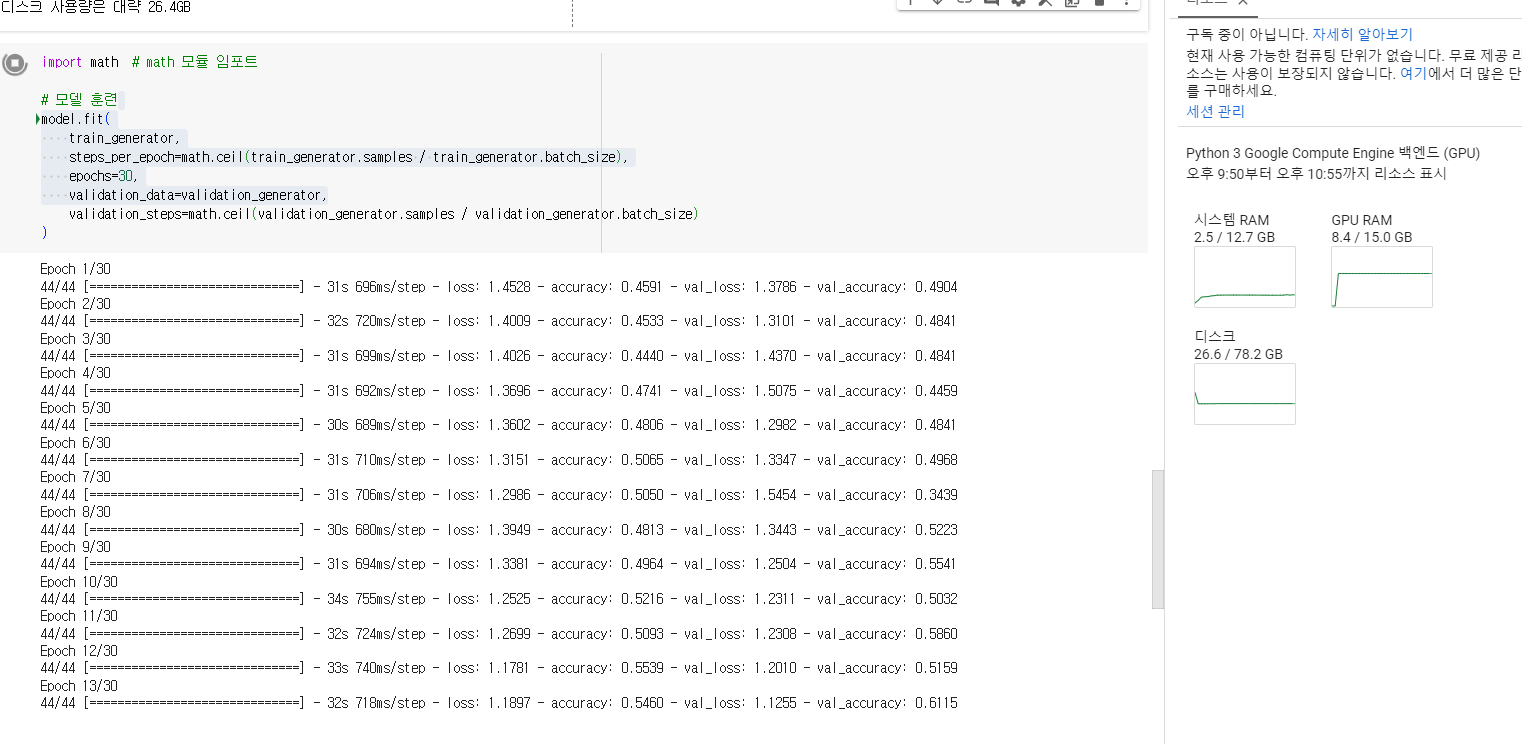

- EPOCH 10일 때

RAM은 대략 2.1GB
GPU는 대략 8.4GB
디스크 사용량은 대략 26.4GB

- EPOCH 30일 때

RAM은 대략 2.6GB
GPU는 대략 8.4GB
디스크 사용량은 대략 26.7GB

추가 변경

- 레이블 커스텀 적용함

RAM은 대략 2.5GB GPU는 대략 8.1GB 디스크 사용량은 대략 26.4GB

In [17]:
import math  # math 모듈 임포트

# 모델 훈련
model.fit(
    train_generator,
    steps_per_epoch=math.ceil(train_generator.samples / train_generator.batch_size),
    epochs=30,
    validation_data=validation_generator,
    validation_steps=math.ceil(validation_generator.samples / validation_generator.batch_size)
)

Epoch 1/30
44/44 [==============================] - 532s 12s/step - loss: 28.6444 - accuracy: 0.5754 - val_loss: 4.9679 - val_accuracy: 0.8535
Epoch 2/30
44/44 [==============================] - 23s 530ms/step - loss: 5.8708 - accuracy: 0.7414 - val_loss: 1.9036 - val_accuracy: 0.8726
Epoch 3/30
44/44 [==============================] - 26s 593ms/step - loss: 2.6444 - accuracy: 0.7550 - val_loss: 1.1444 - val_accuracy: 0.8917
Epoch 4/30
44/44 [==============================] - 25s 553ms/step - loss: 1.5799 - accuracy: 0.7478 - val_loss: 0.7532 - val_accuracy: 0.8917
Epoch 5/30
44/44 [==============================] - 24s 554ms/step - loss: 1.1200 - accuracy: 0.7364 - val_loss: 0.8760 - val_accuracy: 0.8790
Epoch 6/30
44/44 [==============================] - 24s 544ms/step - loss: 0.9146 - accuracy: 0.7665 - val_loss: 0.4916 - val_accuracy: 0.9045
Epoch 7/30
44/44 [==============================] - 26s 586ms/step - loss: 0.7967 - accuracy: 0.7981 - val_loss: 0.6559 - val_accuracy: 0.9172

# 학습 결과

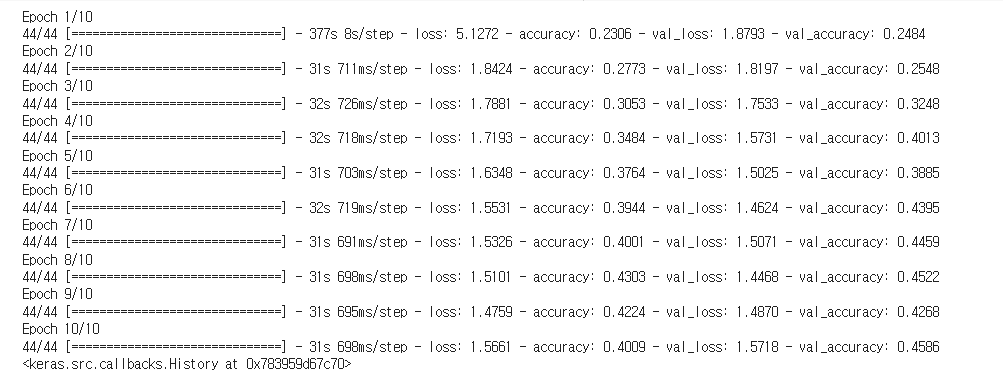

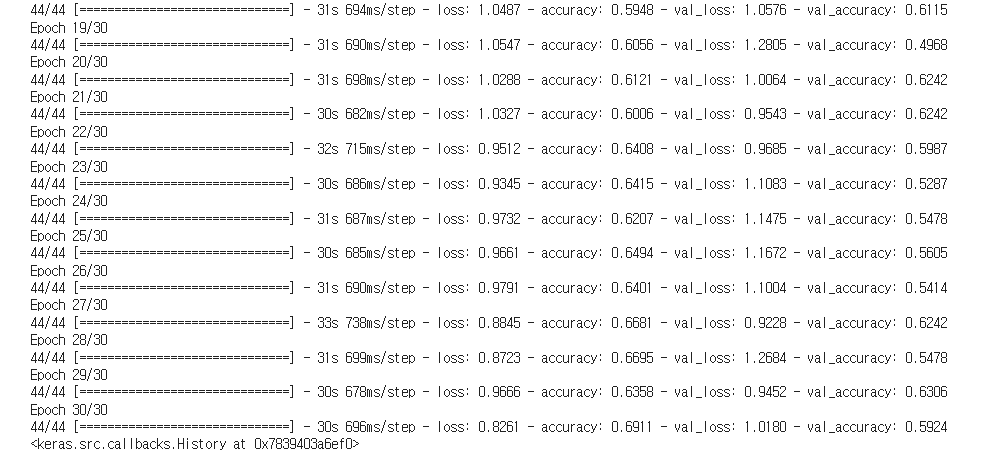

런타임 끊고 에포크 30으로 돌렸지만 결과가 좋지 못한 듯하다..

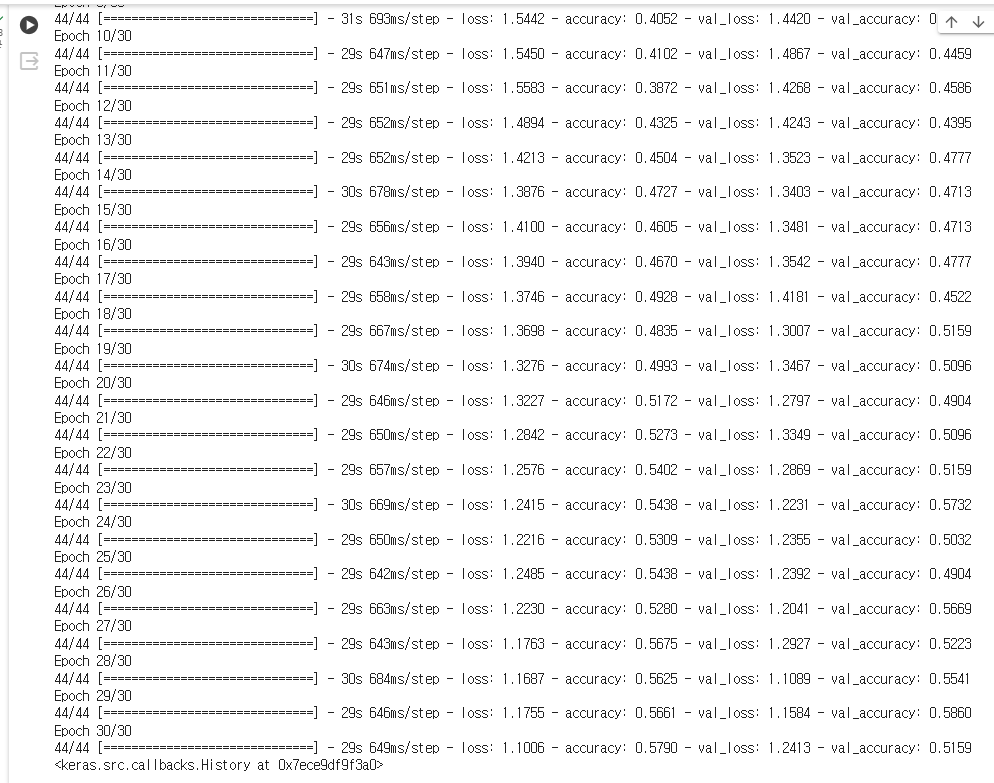

# 추가 변경한 코드에 대한 결과로 정확도 높음!
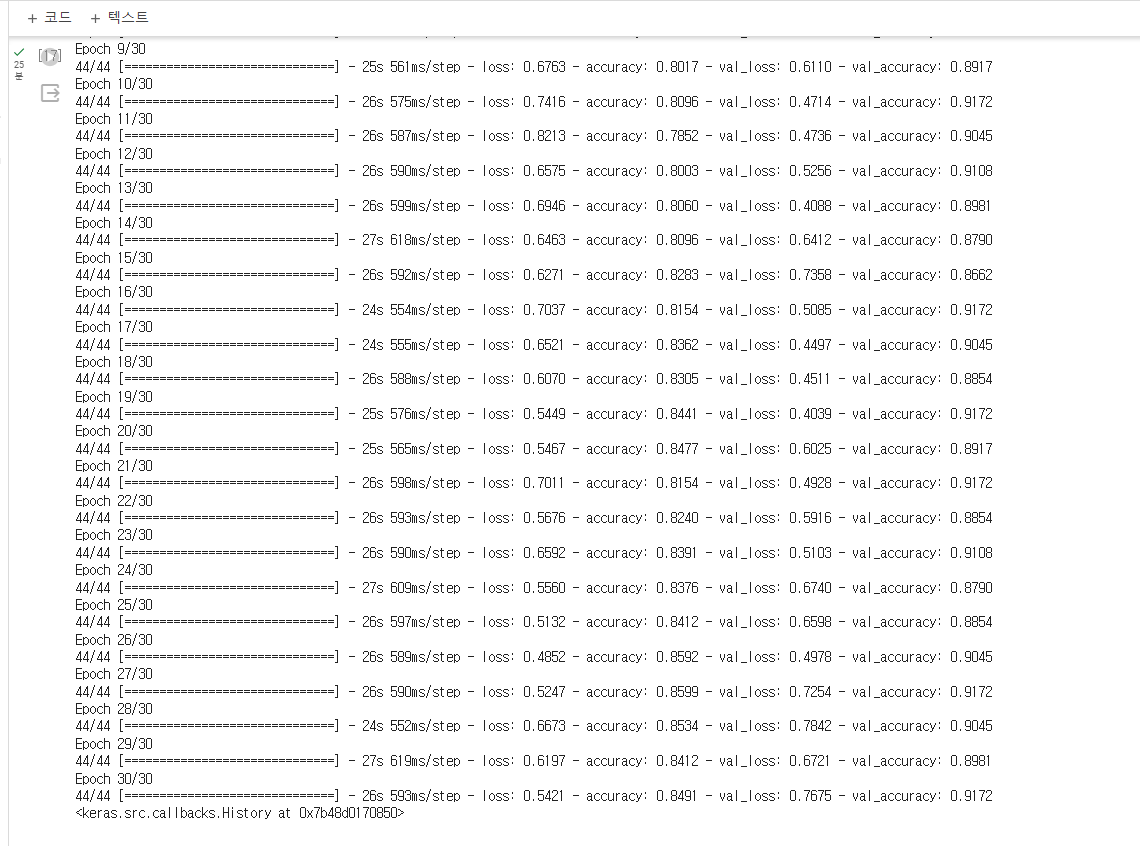

In [ ]:
model_save_path_10 = '/content/drive/MyDrive/GDSC/model/vgg16_gdsc_model.h5'

In [18]:
model_save_path_30_custom = '/content/drive/MyDrive/GDSC/model/vgg16_gdsc_model_30_custom.h5'

In [19]:
# 모델 저장
model.save(model_save_path_30_custom)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
